In [88]:
from IPython.display import Latex

# Simple Linear Perceptron Network
This notebook demonstrates a simple linear neural network with an input later, one hidden layer of perceptrons, and an output layer.

**Input Layer**: The spin values of a monte carlo simulated Ising model.
\begin{align}
\vec{x}=[\sigma_1, \sigma_2, ..., \sigma_N]
\end{align}

**Hidden Layer**: Three heavyside step perceptrons defined by the following linear transformation with one parameter, $\epsilon$.
\begin{align}
W_1\vec{x} + \vec{b_1} = \dfrac{1}{1+\epsilon}
    \begin{bmatrix}
           m(\vec{x})-\epsilon \\
           -m(\vec{x})-\epsilon \\
           m(\vec{x})+\epsilon
         \end{bmatrix}
     =   \begin{bmatrix}
           P_1 \\
           P_2 \\
           P_3
         \end{bmatrix}  
      = \vec{P}
\end{align}
Where $m(x)= \dfrac{1}{N}\sum^N \sigma_i$

The output of each perceptron really depends on the magnetization of lattice and the value of $\epsilon$.

$P_1$: Activates when $m(\vec{x}) > \epsilon$. Correlating to a low temp spin up lattice.

$P_2$: Activates when $m(\vec{x}) < -\epsilon$. Correlating to a low temp spin down lattice.

$P_3$: Activates when $m(\vec{x}) > -\epsilon$. Which either correlates to a high temp unpolarized state, or a low temp spind down lattice.

**Output Layer**: Two nodes, O-low indicating lattice was simulated below the phase change's temperature and O-high indicating it was simulated above that temperature. The values of each node is determined by the following linear transformation
\begin{align}
W_2\vec{P} = \begin{bmatrix}
           2 & 2 & -1 \\
           -2 & -2 & 1
         \end{bmatrix}
       \vec{P}
      = \begin{bmatrix}
           O_{low} \\
           O_{high}
         \end{bmatrix}
\end{align}

This basically ensures that the $O_{low}$ is always 1 if $P_1$ or $P_2$ are high it's indicated that polarization is present indicated low temp. And that $O_{high}$ is only high if both $P_3$ is high and $P_1$ is low, indicating not polarization and therefore a high temperature.

The question we have for this model is what value of $\epsilon$ returns the least amount of error for predicting whether a given lattice is from a temperature below or above the Curie Temp.

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as r
import MetroSim as met

# Constants
TJ = 2/np.log(1+np.sqrt(2)) # The known phase change temperature

In [90]:
# Preparing Data
datatable = pd.read_csv('20_unknown.csv', index_col=0) # Download a premade data set
data = datatable.values
randomized = np.random.permutation(data) # randomizing allows use to use small batches for back progration when
# attempting to find the optimal epsilon

In [91]:
def pol(x): # Function to immitate a Heaveside step
    for i in np.arange(len(x)):
        if x[i]>0:
            x[i] = 1
        else: 
            x[i] = 0
    return x

def W1(x, e, flORList=0): # Takes the input spin values and outputs the perceptron's values
    if flORList == 1:
        m = x
    else:
        m = x.sum()/len(x)
    W = [m-e, 0-m-e, m+e]
    W = [(1.0/(1.0+e))*i for i in W]
    return m, W

def W2(y): # Takes in the Perceptrons values and outputs the output layer values
    W = np.array(([2, 2, -1],[-2, -2, 1]))
    out = W.dot(y)
    return out

In [92]:
# The Cost Function will take in a batch of lattices with their known temperature and calculate the 'cost',
# which is the amount of error, our first transformation W1 will have with a given epsilon value.

def costf(e, k): # e is the epsilon and k is the batch array
    temp = k[:,0]
    spins = k[:,1:]
    totalcost = 0
    for i in np.arange(len(temp)):
        m, W = W1(spins[i], e)
        if temp[i] < TJ and m>0:
            a = np.power(1-W[0],2.0)
            b = np.power(W[1],2.0)
            c = np.power(1-W[2],2.0)
            totalcost += np.sqrt(a+b+c)
        elif temp[i] < TJ and m<0:
            a = np.power(W[0],2.0)
            b = np.power(1-W[1],2.0)
            c = np.power(W[2],2.0)
            totalcost += np.sqrt(a+b+c)
        else:
            a = np.power(W[0],2.0)
            b = np.power(W[1],2.0)
            c = np.power(1-W[2],2.0)
            totalcost += np.sqrt(a+b+c)
    cost = totalcost/len(temp)
    return cost


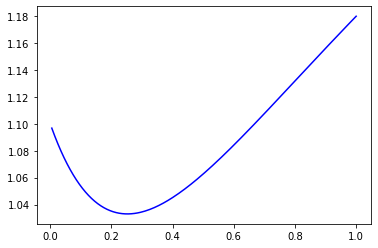

0.25

In [93]:
# Graphing the Cost function over different values in 0 < epsilon < 1
e = np.arange(0.005,1.005, 0.005)
cost = []

for h in e:
    l = costf(h, randomized)
    cost.append(l)
    
plt.plot(e, cost, 'b')
plt.show()
j= cost.index(min(cost))
e[j] # shows the value of epsilon that we've calculated the least cost

It's important to point out that this optimized epsilon is dependant on the data we've put into it. Obviously lattices that werent allowed enough steps in the simulation will be more varied and lead to a different epsilon. But also full simulated lattices of different edge lengths (eg 10 vs 20) will lead to different epsilons. This means that an epsilon optimized for a certain edge length is most accurate for predicting the state of lattices with that same edge length.

In [94]:
def Transform(e, vec): # e value of epsilon, vec list [temp, s0, s1, s2...]
    m, W = W1(vec, e)
    W = pol(W)
    out = W2(W)
    out = pol(out)
    return out

In [30]:
# Checking the efficiency of the epsilon
def check(e, numChecks, edge, stps):
    i = 0
    right = 0
    wrong = 0
    while i < numChecks:
        t = r.randint(1,30)/10.0
        m = met.func(stps, edge, t)
        latt = m.flatten()
        out = Transform(e, latt)
        if (t<TJ and out[0]==1 and out[1]==0) or (t>TJ and out[0]==0 and out[0]==1):
            right += 1
        else:
            wrong +=1
        i += 1
    return right/numChecks, right/numChecks


In [31]:
rt, wr = check(e[j], 500, 20, 10000)


0.686


In [95]:
# Graphing Acceptance and Decline
eps = e[j]
m = np.arange(-1.0,1.01,0.01)
W = []
for i in m:
    mag , k = W1(i, eps, 1)
    W.append(k)
    
def dissect(e, k): # e is the epsilon and k is the batch array
    temp = k[:,0]
    spins = k[:,1:]
    mag = []
    for i in np.arange(len(temp)):
        mag.append(spins[i,:].sum()/len(spins[i,:]))
    return temp, mag

temp, mag =dissect(0.18, randomized)
randY = [r.uniform(-1, 1) for i in mag]

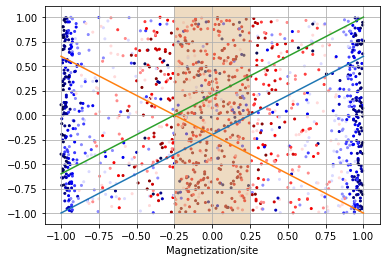

In [112]:
plt.plot(m, W)
plt.scatter(mag, randY, c=temp, cmap= "seismic", s = 4)
plt.grid(True)
plt.axvspan(-eps, eps, facecolor='burlywood', alpha=0.5)
plt.xlabel('Magnetization/site')
plt.show()

The graph above helps us visualize the ability for this model to falsely categorize the data. Each dot's place on the x axis is magnetization/site of that lattice - the y component is random meant to dispurse the dots for visual discernment. The lower the temperature the lattice was simulated at (the bluer the dot) the more likely the magnetization/site is to be closer to -1 or 1. Lattices simulated at higher temps (the redder dots) are more likely to have a m around zero but also can vary widely.

Each line corresponds to a Perceptron in the hidden layer of the model. If for a given magnetization if the  y component of the line is above zero, the perceptron turns to one. Note that $P_1$ (yellow) and $P_2$ (blue) are never above the x-axis at the same time. The tan area of the graph is when $P_3$ (green) is above the x-axis and $P_1$ is not. This range in x are the values for which the lattice is categorized as non-polarized.

Note the large amount of red dots outside of the tan region, and the blue dots inside of it. The blue dots can be blamed on their simulation not having enough steps for them to reach polarization. But the red dots vary so much in magnetization that the model is unable to properly categorize many of them.